<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:03<00:00, 50.1MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


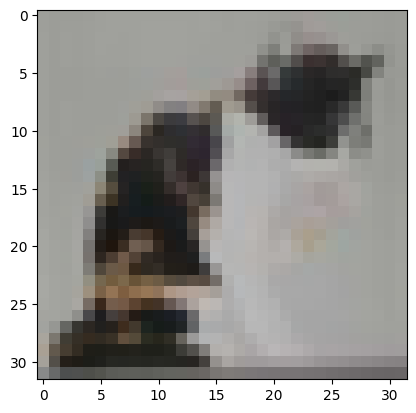

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train), transforms.RandomRotation(degrees=(-40, 40)), transforms.RandomHorizontalFlip()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [6]:
#Creating dataloader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

# **II. Model implementation**

In [7]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.LeakyReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [8]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [9]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])
    self.activation = torch.nn.LeakyReLU(1e-2)

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers[:-1]:
      x = fc_layer(x)
      x = self.activation(x)
    return self.fc_layers[-1](x)


# **III. Training and test**

In [10]:
def compute_Hf_Wf(conv_kernels, Hi, Wi):
    '''Computes the height and width of the output of the final convolutional layer. This function assumes a maxpool2D of kernel 2x2, as well as default stride(1), padding(0) and dilation(0) for both pooling and convolution.
    Parameters:
        * conv_kernels: a list or tuple of the kernels of the successive convolutional layers
        * Hi: Initial height
        * Wi: Initial width

    Outputs:
        * Hf: final height
        * Wf: final width
    '''

    Hf, Wf = Hi, Wi
    for k in conv_kernels:
      Hf = (Hf - (k - 1)) // 2
      Wf = (Wf - (k - 1)) // 2
    return Hf, Wf


conv_kernels, Hi, Wi = (5,3,3), 32, 32
Hf, Wf = compute_Hf_Wf(conv_kernels, Hi, Wi)
print(Hf, Wf)

2 2


In [11]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 64, 128)
out_channels = (64, 128, 256)
conv_kernels = (5, 3, 3)
Hf, Wf = compute_Hf_Wf(conv_kernels, H, W)
fc_dims = (out_channels[-1]*Hf*Wf, 256, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_

In [12]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 670474
Device is cuda


In [13]:
if device=="cuda": model = torch.compile(model)

In [14]:
optimizer = None #Just so that I can resume training

In [15]:
#Training and validation
nb_epochs = 100
if optimizer is None: optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
else: print(optimizer)
criterion = torch.nn.CrossEntropyLoss()
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
    loss_val /= len(val_loader)
    if loss_val < best_loss:
      best_loss = loss_val
      best_model, best_epoch = model, epoch
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()


Epoch: 0


391it [00:43,  9.00it/s]
40it [00:01, 34.52it/s]


Loss_train: 1.8708 and loss_val: 1.6025
Epoch: 1


391it [00:42,  9.18it/s]
40it [00:01, 35.00it/s]


Loss_train: 1.6026 and loss_val: 1.4638
Epoch: 2


391it [00:42,  9.19it/s]
40it [00:01, 33.94it/s]


Loss_train: 1.4974 and loss_val: 1.4066
Epoch: 3


391it [00:42,  9.29it/s]
40it [00:01, 35.10it/s]


Loss_train: 1.4295 and loss_val: 1.3545
Epoch: 4


391it [00:42,  9.28it/s]
40it [00:01, 34.38it/s]


Loss_train: 1.3739 and loss_val: 1.2799
Epoch: 5


391it [00:42,  9.28it/s]
40it [00:01, 34.20it/s]


Loss_train: 1.3235 and loss_val: 1.2078
Epoch: 6


391it [00:42,  9.21it/s]
40it [00:01, 34.92it/s]


Loss_train: 1.2836 and loss_val: 1.1900
Epoch: 7


391it [00:41,  9.39it/s]
40it [00:01, 35.62it/s]


Loss_train: 1.2490 and loss_val: 1.1779
Epoch: 8


391it [00:41,  9.48it/s]
40it [00:01, 33.80it/s]


Loss_train: 1.2225 and loss_val: 1.1272
Epoch: 9


391it [00:41,  9.43it/s]
40it [00:01, 35.32it/s]


Loss_train: 1.1903 and loss_val: 1.1074
Epoch: 10


391it [00:41,  9.42it/s]
40it [00:01, 34.55it/s]


Loss_train: 1.1619 and loss_val: 1.0758
Epoch: 11


391it [00:41,  9.50it/s]
40it [00:01, 35.08it/s]


Loss_train: 1.1334 and loss_val: 1.0450
Epoch: 12


391it [00:41,  9.43it/s]
40it [00:01, 36.09it/s]


Loss_train: 1.1149 and loss_val: 1.0443
Epoch: 13


391it [00:41,  9.51it/s]
40it [00:01, 36.36it/s]


Loss_train: 1.0902 and loss_val: 1.0378
Epoch: 14


391it [00:40,  9.54it/s]
40it [00:01, 35.00it/s]


Loss_train: 1.0707 and loss_val: 1.0036
Epoch: 15


391it [00:41,  9.43it/s]
40it [00:01, 35.21it/s]


Loss_train: 1.0559 and loss_val: 0.9950
Epoch: 16


391it [00:41,  9.39it/s]
40it [00:01, 35.54it/s]


Loss_train: 1.0347 and loss_val: 0.9965
Epoch: 17


391it [00:41,  9.43it/s]
40it [00:01, 35.84it/s]


Loss_train: 1.0183 and loss_val: 0.9663
Epoch: 18


391it [00:41,  9.48it/s]
40it [00:01, 35.64it/s]


Loss_train: 0.9998 and loss_val: 0.9453
Epoch: 19


391it [00:41,  9.45it/s]
40it [00:01, 34.85it/s]


Loss_train: 0.9831 and loss_val: 0.9578
Epoch: 20


391it [00:41,  9.44it/s]
40it [00:01, 35.44it/s]


Loss_train: 0.9724 and loss_val: 0.9360
Epoch: 21


391it [00:41,  9.53it/s]
40it [00:01, 35.49it/s]


Loss_train: 0.9538 and loss_val: 0.9179
Epoch: 22


391it [00:41,  9.52it/s]
40it [00:01, 35.05it/s]


Loss_train: 0.9450 and loss_val: 0.8993
Epoch: 23


391it [00:41,  9.46it/s]
40it [00:01, 35.61it/s]


Loss_train: 0.9294 and loss_val: 0.8782
Epoch: 24


391it [00:41,  9.42it/s]
40it [00:01, 35.42it/s]


Loss_train: 0.9187 and loss_val: 0.8812
Epoch: 25


391it [00:41,  9.42it/s]
40it [00:01, 35.40it/s]


Loss_train: 0.9035 and loss_val: 0.8722
Epoch: 26


391it [00:41,  9.42it/s]
40it [00:01, 35.69it/s]


Loss_train: 0.8959 and loss_val: 0.8537
Epoch: 27


391it [00:41,  9.39it/s]
40it [00:01, 35.96it/s]


Loss_train: 0.8819 and loss_val: 0.8585
Epoch: 28


391it [00:41,  9.48it/s]
40it [00:01, 35.80it/s]


Loss_train: 0.8691 and loss_val: 0.8465
Epoch: 29


391it [00:41,  9.45it/s]
40it [00:01, 35.34it/s]


Loss_train: 0.8603 and loss_val: 0.8470
Epoch: 30


391it [00:41,  9.45it/s]
40it [00:01, 35.23it/s]


Loss_train: 0.8552 and loss_val: 0.8304
Epoch: 31


391it [00:41,  9.44it/s]
40it [00:01, 35.67it/s]


Loss_train: 0.8420 and loss_val: 0.8244
Epoch: 32


391it [00:41,  9.46it/s]
40it [00:01, 35.88it/s]


Loss_train: 0.8329 and loss_val: 0.8204
Epoch: 33


391it [00:41,  9.41it/s]
40it [00:01, 35.55it/s]


Loss_train: 0.8179 and loss_val: 0.8162
Epoch: 34


391it [00:41,  9.45it/s]
40it [00:01, 35.59it/s]


Loss_train: 0.8149 and loss_val: 0.8302
Epoch: 35


391it [00:41,  9.44it/s]
40it [00:01, 35.23it/s]


Loss_train: 0.8096 and loss_val: 0.7956
Epoch: 36


391it [00:41,  9.41it/s]
40it [00:01, 35.83it/s]


Loss_train: 0.7958 and loss_val: 0.7957
Epoch: 37


391it [00:41,  9.44it/s]
40it [00:01, 35.38it/s]


Loss_train: 0.7901 and loss_val: 0.7868
Epoch: 38


391it [00:41,  9.46it/s]
40it [00:01, 35.11it/s]


Loss_train: 0.7807 and loss_val: 0.8011
Epoch: 39


391it [00:41,  9.35it/s]
40it [00:01, 35.70it/s]


Loss_train: 0.7734 and loss_val: 0.7755
Epoch: 40


391it [00:41,  9.46it/s]
40it [00:01, 34.35it/s]


Loss_train: 0.7713 and loss_val: 0.7738
Epoch: 41


391it [00:41,  9.47it/s]
40it [00:01, 34.77it/s]


Loss_train: 0.7662 and loss_val: 0.7777
Epoch: 42


391it [00:41,  9.44it/s]
40it [00:01, 34.73it/s]


Loss_train: 0.7551 and loss_val: 0.7557
Epoch: 43


391it [00:41,  9.44it/s]
40it [00:01, 35.85it/s]


Loss_train: 0.7448 and loss_val: 0.7611
Epoch: 44


391it [00:41,  9.44it/s]
40it [00:01, 35.58it/s]


Loss_train: 0.7421 and loss_val: 0.7811
Epoch: 45


391it [00:41,  9.49it/s]
40it [00:01, 35.97it/s]


Loss_train: 0.7384 and loss_val: 0.7748
Epoch: 46


391it [00:41,  9.48it/s]
40it [00:01, 35.25it/s]


Loss_train: 0.7250 and loss_val: 0.7496
Epoch: 47


391it [00:41,  9.51it/s]
40it [00:01, 35.69it/s]


Loss_train: 0.7213 and loss_val: 0.7635
Epoch: 48


391it [00:41,  9.52it/s]
40it [00:01, 36.10it/s]


Loss_train: 0.7169 and loss_val: 0.7540
Epoch: 49


391it [00:41,  9.53it/s]
40it [00:01, 35.26it/s]


Loss_train: 0.7164 and loss_val: 0.7347
Epoch: 50


391it [00:41,  9.53it/s]
40it [00:01, 35.67it/s]


Loss_train: 0.7088 and loss_val: 0.7419
Epoch: 51


391it [00:40,  9.56it/s]
40it [00:01, 34.64it/s]


Loss_train: 0.6976 and loss_val: 0.7377
Epoch: 52


391it [00:41,  9.50it/s]
40it [00:01, 36.17it/s]


Loss_train: 0.6966 and loss_val: 0.7374
Epoch: 53


391it [00:40,  9.56it/s]
40it [00:01, 33.26it/s]


Loss_train: 0.6878 and loss_val: 0.7491
Epoch: 54


391it [00:41,  9.47it/s]
40it [00:01, 35.96it/s]


Loss_train: 0.6829 and loss_val: 0.7270
Epoch: 55


391it [00:40,  9.55it/s]
40it [00:01, 34.91it/s]


Loss_train: 0.6767 and loss_val: 0.7340
Epoch: 56


391it [00:41,  9.41it/s]
40it [00:01, 35.13it/s]


Loss_train: 0.6709 and loss_val: 0.7286
Epoch: 57


391it [00:41,  9.39it/s]
40it [00:01, 35.61it/s]


Loss_train: 0.6702 and loss_val: 0.7179
Epoch: 58


391it [00:41,  9.38it/s]
40it [00:01, 34.76it/s]


Loss_train: 0.6679 and loss_val: 0.7338
Epoch: 59


391it [00:41,  9.33it/s]
40it [00:01, 35.41it/s]


Loss_train: 0.6612 and loss_val: 0.7344
Epoch: 60


391it [00:41,  9.41it/s]
40it [00:01, 35.48it/s]


Loss_train: 0.6510 and loss_val: 0.7240
Epoch: 61


391it [00:41,  9.37it/s]
40it [00:01, 34.28it/s]


Loss_train: 0.6538 and loss_val: 0.7223
Epoch: 62


391it [00:41,  9.42it/s]
40it [00:01, 35.44it/s]


Loss_train: 0.6476 and loss_val: 0.7192
Epoch: 63


391it [00:41,  9.44it/s]
40it [00:01, 34.79it/s]


Loss_train: 0.6469 and loss_val: 0.6953
Epoch: 64


391it [00:41,  9.50it/s]
40it [00:01, 36.00it/s]


Loss_train: 0.6388 and loss_val: 0.7217
Epoch: 65


391it [00:41,  9.52it/s]
40it [00:01, 35.76it/s]


Loss_train: 0.6345 and loss_val: 0.7124
Epoch: 66


391it [00:40,  9.54it/s]
40it [00:01, 35.72it/s]


Loss_train: 0.6312 and loss_val: 0.7140
Epoch: 67


391it [00:40,  9.54it/s]
40it [00:01, 33.61it/s]


Loss_train: 0.6249 and loss_val: 0.6921
Epoch: 68


391it [00:41,  9.43it/s]
40it [00:01, 35.21it/s]


Loss_train: 0.6249 and loss_val: 0.7069
Epoch: 69


391it [00:41,  9.45it/s]
40it [00:01, 34.93it/s]


Loss_train: 0.6196 and loss_val: 0.7225
Epoch: 70


391it [00:41,  9.46it/s]
40it [00:01, 35.56it/s]


Loss_train: 0.6145 and loss_val: 0.6937
Epoch: 71


391it [00:40,  9.62it/s]
40it [00:01, 34.04it/s]


Loss_train: 0.6128 and loss_val: 0.6917
Epoch: 72


391it [00:40,  9.59it/s]
40it [00:01, 35.37it/s]


Loss_train: 0.6058 and loss_val: 0.7118
Epoch: 73


391it [00:40,  9.57it/s]
40it [00:01, 35.60it/s]


Loss_train: 0.6028 and loss_val: 0.6925
Epoch: 74


391it [00:40,  9.64it/s]
40it [00:01, 34.83it/s]


Loss_train: 0.6030 and loss_val: 0.6864
Epoch: 75


391it [00:40,  9.54it/s]
40it [00:01, 35.38it/s]


Loss_train: 0.5975 and loss_val: 0.7054
Epoch: 76


391it [00:40,  9.57it/s]
40it [00:01, 34.53it/s]


Loss_train: 0.5931 and loss_val: 0.6863
Epoch: 77


391it [00:40,  9.64it/s]
40it [00:01, 34.39it/s]


Loss_train: 0.5878 and loss_val: 0.6899
Epoch: 78


391it [00:40,  9.58it/s]
40it [00:01, 36.49it/s]


Loss_train: 0.5858 and loss_val: 0.7026
Epoch: 79


391it [00:40,  9.61it/s]
40it [00:01, 35.40it/s]


Loss_train: 0.5841 and loss_val: 0.6850
Epoch: 80


391it [00:40,  9.57it/s]
40it [00:01, 35.52it/s]


Loss_train: 0.5790 and loss_val: 0.7090
Epoch: 81


391it [00:40,  9.59it/s]
40it [00:01, 35.93it/s]


Loss_train: 0.5789 and loss_val: 0.6852
Epoch: 82


391it [00:41,  9.52it/s]
40it [00:01, 35.23it/s]


Loss_train: 0.5743 and loss_val: 0.6956
Epoch: 83


391it [00:41,  9.41it/s]
40it [00:01, 34.91it/s]


Loss_train: 0.5717 and loss_val: 0.6796
Epoch: 84


391it [00:41,  9.47it/s]
40it [00:01, 35.65it/s]


Loss_train: 0.5651 and loss_val: 0.6920
Epoch: 85


391it [00:41,  9.48it/s]
40it [00:01, 34.81it/s]


Loss_train: 0.5699 and loss_val: 0.6733
Epoch: 86


391it [00:41,  9.49it/s]
40it [00:01, 35.97it/s]


Loss_train: 0.5599 and loss_val: 0.6964
Epoch: 87


391it [00:41,  9.50it/s]
40it [00:01, 35.54it/s]


Loss_train: 0.5597 and loss_val: 0.6760
Epoch: 88


391it [00:41,  9.51it/s]
40it [00:01, 35.99it/s]


Loss_train: 0.5562 and loss_val: 0.6801
Epoch: 89


391it [00:41,  9.47it/s]
40it [00:01, 35.34it/s]


Loss_train: 0.5525 and loss_val: 0.6896
Epoch: 90


391it [00:41,  9.44it/s]
40it [00:01, 34.85it/s]


Loss_train: 0.5496 and loss_val: 0.6778
Epoch: 91


391it [00:40,  9.55it/s]
40it [00:01, 35.84it/s]


Loss_train: 0.5455 and loss_val: 0.6897
Epoch: 92


391it [00:41,  9.51it/s]
40it [00:01, 35.69it/s]


Loss_train: 0.5449 and loss_val: 0.6768
Epoch: 93


391it [00:41,  9.49it/s]
40it [00:01, 35.74it/s]


Loss_train: 0.5423 and loss_val: 0.6702
Epoch: 94


391it [00:41,  9.49it/s]
40it [00:01, 34.38it/s]


Loss_train: 0.5397 and loss_val: 0.6761
Epoch: 95


391it [00:40,  9.55it/s]
40it [00:01, 35.85it/s]


Loss_train: 0.5420 and loss_val: 0.6753
Epoch: 96


391it [00:41,  9.51it/s]
40it [00:01, 35.09it/s]


Loss_train: 0.5365 and loss_val: 0.6656
Epoch: 97


391it [00:40,  9.55it/s]
40it [00:01, 35.94it/s]


Loss_train: 0.5296 and loss_val: 0.6684
Epoch: 98


391it [00:41,  9.47it/s]
40it [00:01, 35.22it/s]


Loss_train: 0.5281 and loss_val: 0.6692
Epoch: 99


391it [00:41,  9.51it/s]
40it [00:01, 35.83it/s]

Loss_train: 0.5296 and loss_val: 0.6651


Time elapsed: 42.215880155563354
Seconds per epoch: 0.42215880155563357
Best epoch: 99
Best loss: 0.6651


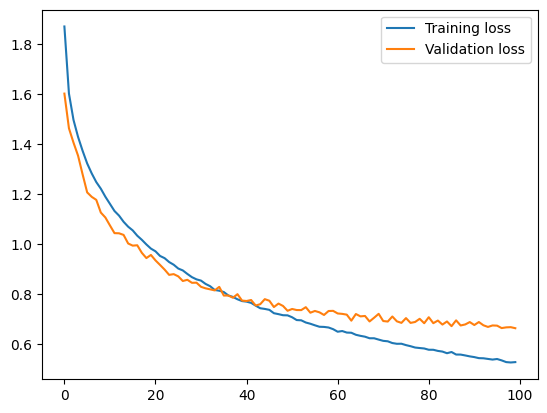

In [16]:
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {best_epoch}")
print(f"Best loss: {best_loss:.4f}")

epochs = range(nb_epochs)

plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [17]:
#Test on val data
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(val_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(val_loader)

  print(f"Loss_test: {loss_test:.4f}")

Now testing...


40it [00:01, 34.87it/s]

Loss_test: 0.6651


<Axes: >

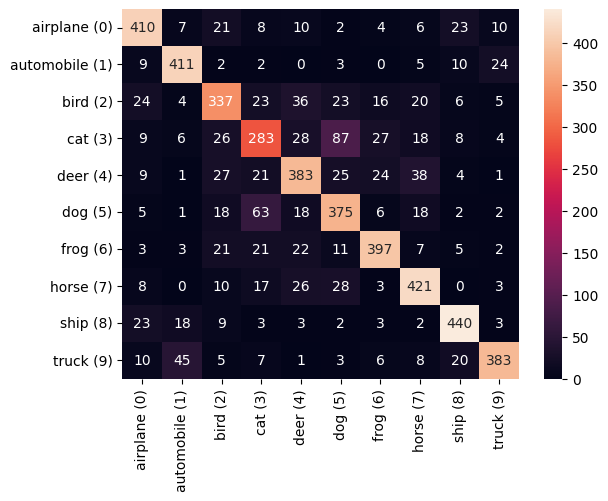

In [18]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [19]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.768


In [20]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)
print("Mean of accuracies: ", accuracies_df["Accuracy"].mean())

                Accuracy
automobile (1)  0.881974
ship (8)        0.869565
airplane (0)    0.818363
horse (7)       0.815891
frog (6)        0.806911
truck (9)       0.784836
dog (5)         0.738189
deer (4)        0.718574
bird (2)        0.682186
cat (3)         0.570565
Mean of accuracies:  0.7687054683461925


In [21]:
checkpoint = {
    "model": best_model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "best_loss": best_loss,
    "epoch": best_epoch
}

# Save to a file in the working directory
torch.save(checkpoint, "/kaggle/working/checkpoint_LeakyReLU.pth")